
# Classificação: detecção de vulnerabilidade de injeção SQL cega

Este notebook considera o problema da detecção de vulnerabilidades de injeção SQL cega usando o método de Classificação. Especificamente, dado o tempo de ida e volta (RTT) de um URL que foi solicitado ao adormecer por alguns segundos, o objetivo é prever se o URL é vulnerável a uma injeção SQL cega (rótulo 1) ou se é seguro ( label 0).

SQL Injection (SQLi) é um tipo de ataque de injeção que possibilita a execução de instruções SQL maliciosas. Essas instruções controlam um servidor de banco de dados por trás de um aplicativo da web. Os atacantes podem usar as vulnerabilidades do SQL Injection para contornar as medidas de segurança do aplicativo.

** Conjunto de dados **

Os conjuntos de dados de treinamento e teste para este problema são fornecidos no arquivo `dataset_50000_2.csv`. Cada linha nesses arquivos corresponde a um URL, com a coluna 2 contendo o atraso de inatividade injetado e a coluna 3 contendo o RTT. A última coluna contém o rótulo da classe e é baseada no rótulo do URL, seguro(0) ou vulnerável(1).

O conjunto de dados contém um total de 100.000 URLs, das quais a primeira metade é vulnerável, enquanto as restantes são todas seguras.

**Otimização**

O objetivo é otimizar o algoritmo de classificação para velocidade e especificidade. Mais especificamente, ele precisa testar um único URL dentro de alguns segundos e ter um FPR menor que 0,0001 (1 em 10.000)

In [ ]:
!pip install cfm

Import libraries

In [ ]:
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics as metrics
import pickle
import timeit
import seaborn as sns
import svc_test as svc
import requests
import numpy as np

from sklearn.utils.multiclass import unique_labels
sns.set()

# Parte (a): Exploração de Dados

1. Colete RTTS de URLs seguras e vulneráveis e salve-as em arquivos CSV.

2. Compare os RTTs seguros e vulneráveis, visualizando-os e comparando sua média (bem como outras métricas).

** Nota: ** Para coletar milhares de RTTs em um período de tempo razoável, foi escrito um script que faz solicitações http de forma assíncrona.

In [ ]:
# 50,000 RTTs, metade vulnerável e a outra metade segura com 2s de sleep delay (atraso)
dataset_df = pd.read_csv('dataset_50000_2.csv')

In [ ]:
dataset_df.head()

,URL,Sleep Delay,RTT,Vulnerable
0,http://localhost:5000/vulnerable/1/page?id=SLE...,2,14.356463,1
1,http://localhost:5000/vulnerable/2/page?id=SLE...,2,11.794838,1
2,http://localhost:5000/vulnerable/3/page?id=SLE...,2,15.530525,1
3,http://localhost:5000/vulnerable/4/page?id=SLE...,2,15.984062,1
4,http://localhost:5000/vulnerable/5/page?id=SLE...,2,12.523224,1


ECDFs avalia o ajuste de uma distribuição aos seus dados, para ver os percentis estimados para a população e os percentis reais para os valores de amostra, e para comparar distribuições amostrais.

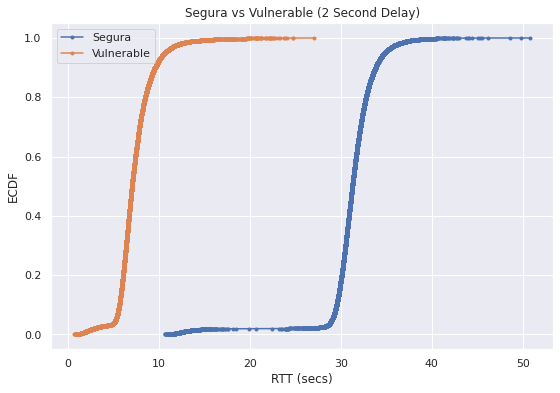

In [ ]:
# Divide os dados em urls 'Vulnerable' e 'Safe'
vul_data = dataset_df[dataset_df['Vulnerable']==1]
safe_data = dataset_df[dataset_df['Vulnerable']==0]

# Calcula ECDFs (empirical cumulative distribution function)
vul_ecdf = ECDF(vul_data['RTT']) 
safe_ecdf = ECDF(safe_data['RTT'])

plt.figure(figsize=(9, 6))

_ = plt.plot(vul_ecdf.x, vul_ecdf.y, marker='.')
_ = plt.plot(safe_ecdf.x, safe_ecdf.y, marker='.')
_ = plt.title('Segura vs Vulnerable (2 Second Delay)')
_ = plt.legend(('Segura', 'Vulnerable'), loc='best')
_ = plt.xlabel('RTT (secs)')
_ = plt.ylabel('ECDF')

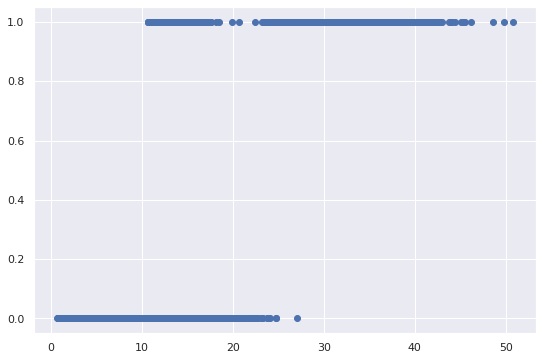

In [ ]:
plt.figure(figsize=(9, 6))
_ = plt.scatter(dataset_df['RTT'], dataset_df['Vulnerable'])

** Observações: ** O gráfico mostra que a maioria dos RTTs para URLs seguros e vulneráveis é muito maior do que o esperado. Serão utilizados os dados como estão para treinar o classificador.

## Part (b): Treinando o Classificador

Utilizando Classificador de Vetores de Suporte.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_df['RTT'], dataset_df['Vulnerable'], test_size=0.41, random_state=0)

In [ ]:
# Train the model
svc_model = SVC(C=10, gamma='auto', kernel = 'rbf', probability=True)
svc_model.fit(np.array(x_train).reshape(-1,1), y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Parte (c): Avaliando e Otimizando

1. Avaliando o modelo usando os dados de teste
2. Fazendo previsões com novos dados

** 1 Avaliando o modelo usando os dados de teste **

In [ ]:
# Fazendo predição com os dados de teste
y_predict = svc_model.predict(np.array(x_test).reshape(-1,1))

In [ ]:
print('O resultado da acuracia é: {}'.format(accuracy_score(y_test, y_predict)))

O resultado da acuracia é: 0.9903414634146341


In [ ]:
print('Matriz de confusão')
print(confusion_matrix(y_test, y_predict))

Matriz de confusão
[[10254     3]
 [  195 10048]]


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print('The FPR is: {}'.format(fp/(fp+tn)))
print('The FNR is {}'.format(fn/(fn+tp)))

The FPR is: 0.0002924831822170225
The FNR is 0.01903739138924143


In [ ]:
# Salva o modelo treinado para uso posterior
filename = 'svc_final_model.pickle'
pickle.dump(svc_model, open(filename, 'wb'))

** 2 Fazendo previsões com novos dados **

In [ ]:
def test(url):
    '''
    Retorna se a url é vulnerável ('vulnerable'- label 1) ou segura ('safe'- label 0)
    '''
    
    # Carrega o modelo SVC treinado
    svc_model = pickle.load(open('svc_final_model.pickle', 'rb'))

    sleep_delay = 2 # O mesmo sleep delay usado durante o treinamento do modelo
    start = timeit.default_timer()
    resp = requests.get(url + 'SLEEP({})'.format(sleep_delay))
    rtt = np.array(timeit.default_timer() - start).reshape(-1,1)
    
    return svc_model.predict(rtt)[0]

In [ ]:
test('https://g1.globo.com/')

0

In [ ]:
test('http://www.ica.ele.puc-rio.br/covid/')

0

In [ ]:
test('https://www.itau.com.br/')

0